## 模型选择、欠拟合和过拟合
### 多项式回归

In [3]:
import math
import numpy as np
import torch
from torch import nn 
import sys
sys.path.append(r"/Users/kingsleycheng/Documents/github/UCAS/DeepLearning/mytorch/")
import mytorch

#### 生成数据集

In [4]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degree) # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train+n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1) # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x ,dtype=torch.float32)
                                           for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.6346],
         [-1.5392]]),
 tensor([[ 1.0000e+00, -6.3464e-01,  2.0138e-01, -4.2602e-02,  6.7592e-03,
          -8.5792e-04,  9.0745e-05, -8.2272e-06,  6.5266e-07, -4.6023e-08,
           2.9208e-09, -1.6851e-10,  8.9120e-12, -4.3507e-13,  1.9722e-14,
          -8.3443e-16,  3.3098e-17, -1.2356e-18,  4.3564e-20, -1.4551e-21],
         [ 1.0000e+00, -1.5392e+00,  1.1846e+00, -6.0781e-01,  2.3389e-01,
          -7.2003e-02,  1.8472e-02, -4.0617e-03,  7.8150e-04, -1.3366e-04,
           2.0573e-05, -2.8788e-06,  3.6926e-07, -4.3722e-08,  4.8070e-09,
          -4.9328e-10,  4.7454e-11, -4.2967e-12,  3.6742e-13, -2.9766e-14]]),
 tensor([ 3.3791, -4.4143]))

#### 对模型进行训练和测试

In [12]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = mytorch.Accumulator(2) # 损失的总和,样本数量
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction="none")
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_features.shape[0])
    train_iter = mytorch.load_array((train_features, train_labels.reshape(-1,1)),batch_size)
    test_iter = mytorch.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = mytorch.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                                xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                                legend=['train', 'test'])
    for epoch in range(num_epochs):
        mytorch.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1)% 20 ==0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), 
                                   evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

#### 三阶多项式函数拟合(正常)

weight: [[ 5.0040007  1.2227106 -3.4008424  5.561259 ]]


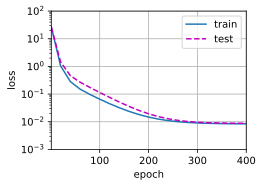

In [14]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:,:4],
      labels[:n_train], labels[n_train:])

#### 线性函数拟合(欠拟合)

weight: [[3.134942  4.7027807]]


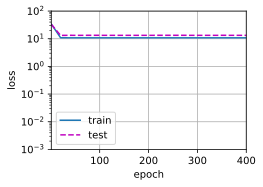

In [15]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:,:2],
      labels[:n_train], labels[n_train:])

#### 高阶多项式函数拟合(过拟合)

weight: [[ 4.982275    1.2866056  -3.3040445   5.2057695  -0.22401431  1.0293592
   0.05601111  0.1839282   0.12645137 -0.14363244  0.02274609 -0.03932726
  -0.10307376  0.15523332  0.06525228 -0.19976349 -0.18277456 -0.15985362
  -0.09637938 -0.05572492]]


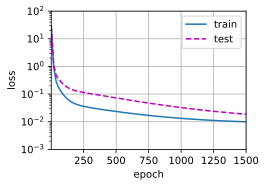

In [17]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:,:],
      labels[:n_train], labels[n_train:], num_epochs=1500)